SBI (100k simulations) on SDE data with different intensity of dynamical noise, ranging from $10^{-6}$ to $1$. The outputs are used to construct the "SBI 100,000" curves on Fig 3.

In [1]:
import os
import sys
import time
import errno
import time
import timeit
import json

import numpy as np

import re
import pandas as pd
import seaborn as sns

In [2]:
import numba
from numba import jit

In [3]:
import torch

import sbi.utils as utils
from sbi.inference.base import infer

from sbi.inference import SNPE, prepare_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import analysis as analysis

from scipy import signal
from scipy.signal import hilbert
from scipy import stats as spstats
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import mode

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from IPython.display import HTML

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
cwd = os.getcwd()
cwd

'/home/tng/Documents/montbrio/benchmark_NEW'

In [7]:
! mkdir -p results

In [8]:
def RMSE(x1, x2):
    return np.sqrt(((x1 - x2) ** 2).mean()) 

In [9]:
def Montbrio_SDEmodel(params, constants, I_input, dt, ts, sigma):
   
    delta, eta, J = params[0], params[1], params[2]
    

    # simulation from initial point
    v = np.zeros_like(ts)  # fast voltage
    r = np.zeros_like(ts)  # slow voltage

    # fixed parameters
    v_init, r_init=constants[0], constants[1]
    
    dt = float(dt)

    v[0],r[0]= v_init, r_init

        
    for i in range(1, ts.shape[0]):
        dr =(delta/np.pi) +2.*r[i-1]*v[i-1]
        dv = v[i-1]**2  -(np.pi*r[i-1])**2 + J*r[i-1]+ eta +I_input[i-1]
        v[i]=v[i-1] + dt * dv + np.sqrt(dt) * sigma * np.random.randn() 
        r[i]=r[i-1] + dt * dr + np.sqrt(dt) * sigma * np.random.randn() 
        
    return np.concatenate((np.array(v).reshape(-1), np.array(r).reshape(-1),))
     

In [10]:
Montbrio_SDEmodel_numba = numba.jit(Montbrio_SDEmodel)

In [11]:
t_init = 0.0
t_final = 100.0
dt = 0.001
I0 = 3.
t_on = 30.
t_off = 60.
v0 = -3.0
r0 = 0.5
ts = np.arange(t_init, t_final, dt)

In [12]:
delta_true = 0.7
eta_true = -4.6
J_true = 14.5
params_true = np.array([delta_true, eta_true, J_true])

Data features:

In [13]:
from MPR_NMM_sumstats import calculate_summary_statistics
#args: y, dt, ts, t_on, _off

In [14]:
from scipy import signal
from scipy.signal import  find_peaks, peak_widths
from scipy import stats as spstats
from scipy.stats import moment
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import mode

In [15]:
calculate_summary_statistics_numba = numba.jit(calculate_summary_statistics)

$10^{-6}$

In [14]:
sigma = 1e-06
sigma_noise = sigma

In [15]:
data_input_filename='data_input_mpr_sd_sigma=' + str(sigma)
data_input_path = cwd+'/Res_syntheticData/data_input_files/'+ str(data_input_filename)+ '.R.npz'
data_input = dict(np.load(data_input_path))

In [16]:
v_obs, r_obs = data_input['vs'], data_input['rs']
nt = data_input['nt']
I_input = data_input['I_input']

In [17]:
X_obs = np.vstack([v_obs, r_obs])

In [21]:
def Montbrio_SDEmodel_Wrapper(params):

    params = np.asarray(params)
    
    t_init = 0.0
    t_final = 100.0

    dt = 0.001
    ts = np.arange(t_init,t_final,dt)
    nt=ts.shape[0]
    
    nIsteps = int((t_final - t_init)/dt)

    I0=3.
    t_on=30.
    t_off=60.

    I_input=[]
    I_input = [0 for i in range(int((t_on - t_init)/dt))]+ [I0 for i in range(int((t_off - t_on)/dt))]+ [0 for i in range(int((t_final - t_off)/dt))]
    I_input =np.asarray(I_input)

    v0 = -3.0
    r0 = 0.5
    
    constants=[v0, r0]
    
    Sim = Montbrio_SDEmodel_numba(params, constants, I_input, dt, ts, sigma_noise)

    #v=Sim[0:nt]
    #r=Sim[nt:2*nt]
    
    summstats_v = torch.as_tensor(calculate_summary_statistics(Sim[0:nt], dt, ts, t_on, t_off))
    summstats_r = torch.as_tensor(calculate_summary_statistics(Sim[nt:2*nt], dt, ts, t_on, t_off))
    
    return np.concatenate([summstats_v, summstats_r]).flatten()


In [22]:
prior_min = [0.2, -10., 5.]
prior_max = [5., -3., 20.]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

In [23]:
num_sims=100000

In [24]:
torch.random.manual_seed(0)
np.random.seed(0)
start_time = time.time()
posterior = infer(Montbrio_SDEmodel_Wrapper, prior, method='SNPE',  num_simulations=num_sims, num_workers=1)
print ("-"*60)
print("--- %s seconds ---" % (time.time() - start_time))

Running 100000 simulations.:   0%|          | 0/100000 [00:00<?, ?it/s]

 Neural network successfully converged after 124 epochs.------------------------------------------------------------
--- 3818.9594433307648 seconds ---


In [25]:
v_obs_summary_stats = torch.as_tensor(calculate_summary_statistics(v_obs, dt, ts, t_on, t_off))
r_obs_summary_stats = torch.as_tensor(calculate_summary_statistics(r_obs, dt, ts, t_on, t_off))
obs_summary_stats = np.concatenate([v_obs_summary_stats, r_obs_summary_stats]).flatten()

In [26]:
num_samples = 500
posterior_sample = posterior.sample((num_samples,), obs_summary_stats).numpy()

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

In [30]:
post_samples = np.array(posterior_sample, dtype='float64')

In [33]:
post_samples.shape

(500, 3)

In [31]:
rmse_prms = []
for sample in range(post_samples.shape[0]) :
    rmse_prms.append(RMSE(post_samples[sample, :], params_true))

In [34]:
np.save('results/sbi_batch_rmse_noise_' + str(sigma) + '_100k.npy', np.array(rmse_prms))

In [35]:
I_input = [0 for i in range(int((t_on - t_init)/dt))]+ [I0 for i in range(int((t_off - t_on)/dt))]+ [0 for i in range(int((t_final - t_off)/dt))]
I_input = np.asarray(I_input)  
constants=[v0, r0]

rmse_fit = []
for sample in range(post_samples.shape[0]):
    y_fit = Montbrio_SDEmodel(post_samples[sample, :], constants, I_input, dt, ts, 0.0)
    rmse_fit.append(RMSE(np.vstack([y_fit[:len(y_fit)//2], y_fit[len(y_fit)//2:]]), X_obs))

In [36]:
np.array(rmse_fit).shape

(500,)

In [38]:
np.save('results/sbi_batch_cost_noise_' + str(sigma) + '_100k.npy', np.array(rmse_fit))

$10^{-5}$

In [16]:
sigma = 1e-05
sigma_noise = sigma

In [17]:
data_input_filename='data_input_mpr_sd_sigma=' + str(sigma)
data_input_path = cwd+'/Res_syntheticData/data_input_files/'+ str(data_input_filename)+ '.R.npz'
data_input = dict(np.load(data_input_path))

In [18]:
v_obs, r_obs = data_input['vs'], data_input['rs']
nt = data_input['nt']
I_input = data_input['I_input']

In [19]:
X_obs = np.vstack([v_obs, r_obs])

In [20]:
def Montbrio_SDEmodel_Wrapper(params):

    params = np.asarray(params)
    
    t_init = 0.0
    t_final = 100.0

    dt = 0.001
    ts = np.arange(t_init,t_final,dt)
    nt=ts.shape[0]
    
    nIsteps = int((t_final - t_init)/dt)

    I0=3.
    t_on=30.
    t_off=60.

    I_input=[]
    I_input = [0 for i in range(int((t_on - t_init)/dt))]+ [I0 for i in range(int((t_off - t_on)/dt))]+ [0 for i in range(int((t_final - t_off)/dt))]
    I_input =np.asarray(I_input)

    v0 = -3.0
    r0 = 0.5
    
    constants=[v0, r0]
    
    Sim = Montbrio_SDEmodel_numba(params, constants, I_input, dt, ts, sigma_noise)

    #v=Sim[0:nt]
    #r=Sim[nt:2*nt]
    
    summstats_v = torch.as_tensor(calculate_summary_statistics(Sim[0:nt], dt, ts, t_on, t_off))
    summstats_r = torch.as_tensor(calculate_summary_statistics(Sim[nt:2*nt], dt, ts, t_on, t_off))
    
    return np.concatenate([summstats_v, summstats_r]).flatten()


In [21]:
prior_min = [0.2, -10., 5.]
prior_max = [5., -3., 20.]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

In [22]:
num_sims=100000

In [23]:
torch.random.manual_seed(0)
np.random.seed(0)
start_time = time.time()
posterior = infer(Montbrio_SDEmodel_Wrapper, prior, method='SNPE',  num_simulations=num_sims, num_workers=1)
print ("-"*60)
print("--- %s seconds ---" % (time.time() - start_time))

Running 100000 simulations.:   0%|          | 0/100000 [00:00<?, ?it/s]

 Neural network successfully converged after 99 epochs.------------------------------------------------------------
--- 3387.726637363434 seconds ---


In [24]:
v_obs_summary_stats = torch.as_tensor(calculate_summary_statistics(v_obs, dt, ts, t_on, t_off))
r_obs_summary_stats = torch.as_tensor(calculate_summary_statistics(r_obs, dt, ts, t_on, t_off))
obs_summary_stats = np.concatenate([v_obs_summary_stats, r_obs_summary_stats]).flatten()

In [25]:
num_samples = 500
posterior_sample = posterior.sample((num_samples,), obs_summary_stats).numpy()

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

In [26]:
post_samples = np.array(posterior_sample, dtype='float64')

In [27]:
post_samples.shape

(500, 3)

In [28]:
rmse_prms = []
for sample in range(post_samples.shape[0]) :
    rmse_prms.append(RMSE(post_samples[sample, :], params_true))

In [29]:
np.save('results/sbi_batch_rmse_noise_' + str(sigma) + '_100k.npy', np.array(rmse_prms))

In [30]:
I_input = [0 for i in range(int((t_on - t_init)/dt))]+ [I0 for i in range(int((t_off - t_on)/dt))]+ [0 for i in range(int((t_final - t_off)/dt))]
I_input = np.asarray(I_input)  
constants=[v0, r0]

rmse_fit = []
for sample in range(post_samples.shape[0]):
    y_fit = Montbrio_SDEmodel(post_samples[sample, :], constants, I_input, dt, ts, 0.0)
    rmse_fit.append(RMSE(np.vstack([y_fit[:len(y_fit)//2], y_fit[len(y_fit)//2:]]), X_obs))

In [31]:
np.array(rmse_fit).shape

(500,)

In [32]:
np.save('results/sbi_batch_cost_noise_' + str(sigma) + '_100k.npy', np.array(rmse_fit))

$10^{-4}$

In [16]:
sigma = 1e-04
sigma_noise = sigma

In [17]:
data_input_filename='data_input_mpr_sd_sigma=' + str(sigma)
data_input_path = cwd+'/Res_syntheticData/data_input_files/'+ str(data_input_filename)+ '.R.npz'
data_input = dict(np.load(data_input_path))

In [18]:
v_obs, r_obs = data_input['vs'], data_input['rs']
nt = data_input['nt']
I_input = data_input['I_input']

In [19]:
X_obs = np.vstack([v_obs, r_obs])

In [20]:
def Montbrio_SDEmodel_Wrapper(params):

    params = np.asarray(params)
    
    t_init = 0.0
    t_final = 100.0

    dt = 0.001
    ts = np.arange(t_init,t_final,dt)
    nt=ts.shape[0]
    
    nIsteps = int((t_final - t_init)/dt)

    I0=3.
    t_on=30.
    t_off=60.

    I_input=[]
    I_input = [0 for i in range(int((t_on - t_init)/dt))]+ [I0 for i in range(int((t_off - t_on)/dt))]+ [0 for i in range(int((t_final - t_off)/dt))]
    I_input =np.asarray(I_input)

    v0 = -3.0
    r0 = 0.5
    
    constants=[v0, r0]
    
    Sim = Montbrio_SDEmodel_numba(params, constants, I_input, dt, ts, sigma_noise)

    #v=Sim[0:nt]
    #r=Sim[nt:2*nt]
    
    summstats_v = torch.as_tensor(calculate_summary_statistics(Sim[0:nt], dt, ts, t_on, t_off))
    summstats_r = torch.as_tensor(calculate_summary_statistics(Sim[nt:2*nt], dt, ts, t_on, t_off))
    
    return np.concatenate([summstats_v, summstats_r]).flatten()


In [21]:
prior_min = [0.2, -10., 5.]
prior_max = [5., -3., 20.]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

In [22]:
num_sims=100000

In [23]:
torch.random.manual_seed(0)
np.random.seed(0)
start_time = time.time()
posterior = infer(Montbrio_SDEmodel_Wrapper, prior, method='SNPE',  num_simulations=num_sims, num_workers=1)
print ("-"*60)
print("--- %s seconds ---" % (time.time() - start_time))

Running 100000 simulations.:   0%|          | 0/100000 [00:00<?, ?it/s]

 Neural network successfully converged after 104 epochs.------------------------------------------------------------
--- 3775.429207086563 seconds ---


In [24]:
v_obs_summary_stats = torch.as_tensor(calculate_summary_statistics(v_obs, dt, ts, t_on, t_off))
r_obs_summary_stats = torch.as_tensor(calculate_summary_statistics(r_obs, dt, ts, t_on, t_off))
obs_summary_stats = np.concatenate([v_obs_summary_stats, r_obs_summary_stats]).flatten()

In [25]:
num_samples = 500
posterior_sample = posterior.sample((num_samples,), obs_summary_stats).numpy()

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

In [26]:
post_samples = np.array(posterior_sample, dtype='float64')

In [27]:
post_samples.shape

(500, 3)

In [28]:
rmse_prms = []
for sample in range(post_samples.shape[0]) :
    rmse_prms.append(RMSE(post_samples[sample, :], params_true))

In [29]:
print(str(sigma))

0.0001


In [30]:
np.save('results/sbi_batch_rmse_noise_' + str(sigma) + '_100k.npy', np.array(rmse_prms))

In [31]:
I_input = [0 for i in range(int((t_on - t_init)/dt))]+ [I0 for i in range(int((t_off - t_on)/dt))]+ [0 for i in range(int((t_final - t_off)/dt))]
I_input = np.asarray(I_input)  
constants=[v0, r0]

rmse_fit = []
for sample in range(post_samples.shape[0]):
    y_fit = Montbrio_SDEmodel(post_samples[sample, :], constants, I_input, dt, ts, 0.0)
    rmse_fit.append(RMSE(np.vstack([y_fit[:len(y_fit)//2], y_fit[len(y_fit)//2:]]), X_obs))

In [32]:
np.array(rmse_fit).shape

(500,)

In [33]:
np.save('results/sbi_batch_cost_noise_' + str(sigma) + '_100k.npy', np.array(rmse_fit))

$10^{-3}$

In [16]:
sigma = 1e-03
sigma_noise = sigma

In [17]:
data_input_filename='data_input_mpr_sd_sigma=' + str(sigma)
data_input_path = cwd+'/Res_syntheticData/data_input_files/'+ str(data_input_filename)+ '.R.npz'
data_input = dict(np.load(data_input_path))

In [18]:
v_obs, r_obs = data_input['vs'], data_input['rs']
nt = data_input['nt']
I_input = data_input['I_input']

In [19]:
X_obs = np.vstack([v_obs, r_obs])

In [20]:
def Montbrio_SDEmodel_Wrapper(params):

    params = np.asarray(params)
    
    t_init = 0.0
    t_final = 100.0

    dt = 0.001
    ts = np.arange(t_init,t_final,dt)
    nt=ts.shape[0]
    
    nIsteps = int((t_final - t_init)/dt)

    I0=3.
    t_on=30.
    t_off=60.

    I_input=[]
    I_input = [0 for i in range(int((t_on - t_init)/dt))]+ [I0 for i in range(int((t_off - t_on)/dt))]+ [0 for i in range(int((t_final - t_off)/dt))]
    I_input =np.asarray(I_input)

    v0 = -3.0
    r0 = 0.5
    
    constants=[v0, r0]
    
    Sim = Montbrio_SDEmodel_numba(params, constants, I_input, dt, ts, sigma_noise)

    #v=Sim[0:nt]
    #r=Sim[nt:2*nt]
    
    summstats_v = torch.as_tensor(calculate_summary_statistics(Sim[0:nt], dt, ts, t_on, t_off))
    summstats_r = torch.as_tensor(calculate_summary_statistics(Sim[nt:2*nt], dt, ts, t_on, t_off))
    
    return np.concatenate([summstats_v, summstats_r]).flatten()


In [21]:
prior_min = [0.2, -10., 5.]
prior_max = [5., -3., 20.]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

In [22]:
num_sims=100000

In [23]:
torch.random.manual_seed(0)
np.random.seed(0)
start_time = time.time()
posterior = infer(Montbrio_SDEmodel_Wrapper, prior, method='SNPE',  num_simulations=num_sims, num_workers=1)
print ("-"*60)
print("--- %s seconds ---" % (time.time() - start_time))

Running 100000 simulations.:   0%|          | 0/100000 [00:00<?, ?it/s]

 Neural network successfully converged after 157 epochs.------------------------------------------------------------
--- 4839.6074278354645 seconds ---


In [24]:
v_obs_summary_stats = torch.as_tensor(calculate_summary_statistics(v_obs, dt, ts, t_on, t_off))
r_obs_summary_stats = torch.as_tensor(calculate_summary_statistics(r_obs, dt, ts, t_on, t_off))
obs_summary_stats = np.concatenate([v_obs_summary_stats, r_obs_summary_stats]).flatten()

In [25]:
num_samples = 500
posterior_sample = posterior.sample((num_samples,), obs_summary_stats).numpy()

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

In [26]:
post_samples = np.array(posterior_sample, dtype='float64')

In [27]:
post_samples.shape

(500, 3)

In [28]:
rmse_prms = []
for sample in range(post_samples.shape[0]) :
    rmse_prms.append(RMSE(post_samples[sample, :], params_true))

In [29]:
print(str(sigma))

0.001


In [30]:
np.save('results/sbi_batch_rmse_noise_' + str(sigma) + '_100k.npy', np.array(rmse_prms))

In [31]:
I_input = [0 for i in range(int((t_on - t_init)/dt))]+ [I0 for i in range(int((t_off - t_on)/dt))]+ [0 for i in range(int((t_final - t_off)/dt))]
I_input = np.asarray(I_input)  
constants=[v0, r0]

rmse_fit = []
for sample in range(post_samples.shape[0]):
    y_fit = Montbrio_SDEmodel(post_samples[sample, :], constants, I_input, dt, ts, 0.0)
    rmse_fit.append(RMSE(np.vstack([y_fit[:len(y_fit)//2], y_fit[len(y_fit)//2:]]), X_obs))

In [32]:
np.array(rmse_fit).shape

(500,)

In [33]:
np.save('results/sbi_batch_cost_noise_' + str(sigma) + '_100k.npy', np.array(rmse_fit))

$10^{-2}$

In [34]:
sigma = 1e-02
sigma_noise = sigma

In [35]:
data_input_filename='data_input_mpr_sd_sigma=' + str(sigma)
data_input_path = cwd+'/Res_syntheticData/data_input_files/'+ str(data_input_filename)+ '.R.npz'
data_input = dict(np.load(data_input_path))

In [36]:
v_obs, r_obs = data_input['vs'], data_input['rs']
nt = data_input['nt']
I_input = data_input['I_input']

In [37]:
X_obs = np.vstack([v_obs, r_obs])

In [38]:
def Montbrio_SDEmodel_Wrapper(params):

    params = np.asarray(params)
    
    t_init = 0.0
    t_final = 100.0

    dt = 0.001
    ts = np.arange(t_init,t_final,dt)
    nt=ts.shape[0]
    
    nIsteps = int((t_final - t_init)/dt)

    I0=3.
    t_on=30.
    t_off=60.

    I_input=[]
    I_input = [0 for i in range(int((t_on - t_init)/dt))]+ [I0 for i in range(int((t_off - t_on)/dt))]+ [0 for i in range(int((t_final - t_off)/dt))]
    I_input =np.asarray(I_input)

    v0 = -3.0
    r0 = 0.5
    
    constants=[v0, r0]
    
    Sim = Montbrio_SDEmodel_numba(params, constants, I_input, dt, ts, sigma_noise)

    #v=Sim[0:nt]
    #r=Sim[nt:2*nt]
    
    summstats_v = torch.as_tensor(calculate_summary_statistics(Sim[0:nt], dt, ts, t_on, t_off))
    summstats_r = torch.as_tensor(calculate_summary_statistics(Sim[nt:2*nt], dt, ts, t_on, t_off))
    
    return np.concatenate([summstats_v, summstats_r]).flatten()


In [39]:
prior_min = [0.2, -10., 5.]
prior_max = [5., -3., 20.]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

In [40]:
num_sims=100000

In [41]:
torch.random.manual_seed(0)
np.random.seed(0)
start_time = time.time()
posterior = infer(Montbrio_SDEmodel_Wrapper, prior, method='SNPE',  num_simulations=num_sims, num_workers=1)
print ("-"*60)
print("--- %s seconds ---" % (time.time() - start_time))

Running 100000 simulations.:   0%|          | 0/100000 [00:00<?, ?it/s]

 Neural network successfully converged after 71 epochs.------------------------------------------------------------
--- 3398.4975831508636 seconds ---


In [42]:
v_obs_summary_stats = torch.as_tensor(calculate_summary_statistics(v_obs, dt, ts, t_on, t_off))
r_obs_summary_stats = torch.as_tensor(calculate_summary_statistics(r_obs, dt, ts, t_on, t_off))
obs_summary_stats = np.concatenate([v_obs_summary_stats, r_obs_summary_stats]).flatten()

In [43]:
num_samples = 500
posterior_sample = posterior.sample((num_samples,), obs_summary_stats).numpy()

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

In [44]:
post_samples = np.array(posterior_sample, dtype='float64')

In [45]:
post_samples.shape

(500, 3)

In [46]:
rmse_prms = []
for sample in range(post_samples.shape[0]) :
    rmse_prms.append(RMSE(post_samples[sample, :], params_true))

In [47]:
print(str(sigma))

0.01


In [48]:
np.save('results/sbi_batch_rmse_noise_' + str(sigma) + '_100k.npy', np.array(rmse_prms))

In [49]:
I_input = [0 for i in range(int((t_on - t_init)/dt))]+ [I0 for i in range(int((t_off - t_on)/dt))]+ [0 for i in range(int((t_final - t_off)/dt))]
I_input = np.asarray(I_input)  
constants=[v0, r0]

rmse_fit = []
for sample in range(post_samples.shape[0]):
    y_fit = Montbrio_SDEmodel(post_samples[sample, :], constants, I_input, dt, ts, 0.0)
    rmse_fit.append(RMSE(np.vstack([y_fit[:len(y_fit)//2], y_fit[len(y_fit)//2:]]), X_obs))

In [50]:
np.array(rmse_fit).shape

(500,)

In [51]:
np.save('results/sbi_batch_cost_noise_' + str(sigma) + '_100k.npy', np.array(rmse_fit))

$1$

In [52]:
sigma = 1
sigma_noise = sigma

In [53]:
data_input_filename='data_input_mpr_sd_sigma=' + str(sigma)
data_input_path = cwd+'/Res_syntheticData/data_input_files/'+ str(data_input_filename)+ '.R.npz'
data_input = dict(np.load(data_input_path))

In [54]:
v_obs, r_obs = data_input['vs'], data_input['rs']
nt = data_input['nt']
I_input = data_input['I_input']

In [55]:
X_obs = np.vstack([v_obs, r_obs])

In [56]:
def Montbrio_SDEmodel_Wrapper(params):

    params = np.asarray(params)
    
    t_init = 0.0
    t_final = 100.0

    dt = 0.001
    ts = np.arange(t_init,t_final,dt)
    nt=ts.shape[0]
    
    nIsteps = int((t_final - t_init)/dt)

    I0=3.
    t_on=30.
    t_off=60.

    I_input=[]
    I_input = [0 for i in range(int((t_on - t_init)/dt))]+ [I0 for i in range(int((t_off - t_on)/dt))]+ [0 for i in range(int((t_final - t_off)/dt))]
    I_input =np.asarray(I_input)

    v0 = -3.0
    r0 = 0.5
    
    constants=[v0, r0]
    
    Sim = Montbrio_SDEmodel_numba(params, constants, I_input, dt, ts, sigma_noise)

    #v=Sim[0:nt]
    #r=Sim[nt:2*nt]
    
    summstats_v = torch.as_tensor(calculate_summary_statistics(Sim[0:nt], dt, ts, t_on, t_off))
    summstats_r = torch.as_tensor(calculate_summary_statistics(Sim[nt:2*nt], dt, ts, t_on, t_off))
    
    return np.concatenate([summstats_v, summstats_r]).flatten()


In [57]:
prior_min = [0.2, -10., 5.]
prior_max = [5., -3., 20.]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

In [58]:
num_sims=100000

In [59]:
torch.random.manual_seed(0)
np.random.seed(0)
start_time = time.time()
posterior = infer(Montbrio_SDEmodel_Wrapper, prior, method='SNPE',  num_simulations=num_sims, num_workers=1)
print ("-"*60)
print("--- %s seconds ---" % (time.time() - start_time))

Running 100000 simulations.:   0%|          | 0/100000 [00:00<?, ?it/s]

 Neural network successfully converged after 98 epochs.------------------------------------------------------------
--- 3824.8263761997223 seconds ---


In [60]:
v_obs_summary_stats = torch.as_tensor(calculate_summary_statistics(v_obs, dt, ts, t_on, t_off))
r_obs_summary_stats = torch.as_tensor(calculate_summary_statistics(r_obs, dt, ts, t_on, t_off))
obs_summary_stats = np.concatenate([v_obs_summary_stats, r_obs_summary_stats]).flatten()

In [61]:
num_samples = 500
posterior_sample = posterior.sample((num_samples,), obs_summary_stats).numpy()

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

In [62]:
post_samples = np.array(posterior_sample, dtype='float64')

In [63]:
post_samples.shape

(500, 3)

In [64]:
rmse_prms = []
for sample in range(post_samples.shape[0]) :
    rmse_prms.append(RMSE(post_samples[sample, :], params_true))

In [65]:
print(str(sigma))

1


In [66]:
np.save('results/sbi_batch_rmse_noise_' + str(sigma) + '_100k.npy', np.array(rmse_prms))

In [67]:
I_input = [0 for i in range(int((t_on - t_init)/dt))]+ [I0 for i in range(int((t_off - t_on)/dt))]+ [0 for i in range(int((t_final - t_off)/dt))]
I_input = np.asarray(I_input)  
constants=[v0, r0]

rmse_fit = []
for sample in range(post_samples.shape[0]):
    y_fit = Montbrio_SDEmodel(post_samples[sample, :], constants, I_input, dt, ts, 0.0)
    rmse_fit.append(RMSE(np.vstack([y_fit[:len(y_fit)//2], y_fit[len(y_fit)//2:]]), X_obs))

In [68]:
np.array(rmse_fit).shape

(500,)

In [69]:
np.save('results/sbi_batch_cost_noise_' + str(sigma) + '_100k.npy', np.array(rmse_fit))

0.5

In [70]:
sigma = 0.5
sigma_noise = sigma

In [71]:
data_input_filename='data_input_mpr_sd_sigma=' + str(sigma)
data_input_path = cwd+'/Res_syntheticData/data_input_files/'+ str(data_input_filename)+ '.R.npz'
data_input = dict(np.load(data_input_path))

In [72]:
v_obs, r_obs = data_input['vs'], data_input['rs']
nt = data_input['nt']
I_input = data_input['I_input']

In [73]:
X_obs = np.vstack([v_obs, r_obs])

In [74]:
def Montbrio_SDEmodel_Wrapper(params):

    params = np.asarray(params)
    
    t_init = 0.0
    t_final = 100.0

    dt = 0.001
    ts = np.arange(t_init,t_final,dt)
    nt=ts.shape[0]
    
    nIsteps = int((t_final - t_init)/dt)

    I0=3.
    t_on=30.
    t_off=60.

    I_input=[]
    I_input = [0 for i in range(int((t_on - t_init)/dt))]+ [I0 for i in range(int((t_off - t_on)/dt))]+ [0 for i in range(int((t_final - t_off)/dt))]
    I_input =np.asarray(I_input)

    v0 = -3.0
    r0 = 0.5
    
    constants=[v0, r0]
    
    Sim = Montbrio_SDEmodel_numba(params, constants, I_input, dt, ts, sigma_noise)

    #v=Sim[0:nt]
    #r=Sim[nt:2*nt]
    
    summstats_v = torch.as_tensor(calculate_summary_statistics(Sim[0:nt], dt, ts, t_on, t_off))
    summstats_r = torch.as_tensor(calculate_summary_statistics(Sim[nt:2*nt], dt, ts, t_on, t_off))
    
    return np.concatenate([summstats_v, summstats_r]).flatten()


In [75]:
prior_min = [0.2, -10., 5.]
prior_max = [5., -3., 20.]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

In [76]:
num_sims=100000

In [77]:
torch.random.manual_seed(0)
np.random.seed(0)
start_time = time.time()
posterior = infer(Montbrio_SDEmodel_Wrapper, prior, method='SNPE',  num_simulations=num_sims, num_workers=1)
print ("-"*60)
print("--- %s seconds ---" % (time.time() - start_time))

Running 100000 simulations.:   0%|          | 0/100000 [00:00<?, ?it/s]

 Neural network successfully converged after 59 epochs.------------------------------------------------------------
--- 3174.8588349819183 seconds ---


In [78]:
v_obs_summary_stats = torch.as_tensor(calculate_summary_statistics(v_obs, dt, ts, t_on, t_off))
r_obs_summary_stats = torch.as_tensor(calculate_summary_statistics(r_obs, dt, ts, t_on, t_off))
obs_summary_stats = np.concatenate([v_obs_summary_stats, r_obs_summary_stats]).flatten()

In [79]:
num_samples = 500
posterior_sample = posterior.sample((num_samples,), obs_summary_stats).numpy()

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

In [80]:
post_samples = np.array(posterior_sample, dtype='float64')

In [81]:
post_samples.shape

(500, 3)

In [82]:
rmse_prms = []
for sample in range(post_samples.shape[0]) :
    rmse_prms.append(RMSE(post_samples[sample, :], params_true))

In [83]:
print(str(sigma))

0.5


In [84]:
np.save('results/sbi_batch_rmse_noise_' + str(sigma) + '_100k.npy', np.array(rmse_prms))

In [85]:
I_input = [0 for i in range(int((t_on - t_init)/dt))]+ [I0 for i in range(int((t_off - t_on)/dt))]+ [0 for i in range(int((t_final - t_off)/dt))]
I_input = np.asarray(I_input)  
constants=[v0, r0]

rmse_fit = []
for sample in range(post_samples.shape[0]):
    y_fit = Montbrio_SDEmodel(post_samples[sample, :], constants, I_input, dt, ts, 0.0)
    rmse_fit.append(RMSE(np.vstack([y_fit[:len(y_fit)//2], y_fit[len(y_fit)//2:]]), X_obs))

In [86]:
np.array(rmse_fit).shape

(500,)

In [87]:
np.save('results/sbi_batch_cost_noise_' + str(sigma) + '_100k.npy', np.array(rmse_fit))

0.2

In [88]:
sigma = 0.2
sigma_noise = sigma

In [89]:
data_input_filename='data_input_mpr_sd_sigma=' + str(sigma)
data_input_path = cwd+'/Res_syntheticData/data_input_files/'+ str(data_input_filename)+ '.R.npz'
data_input = dict(np.load(data_input_path))

In [90]:
v_obs, r_obs = data_input['vs'], data_input['rs']
nt = data_input['nt']
I_input = data_input['I_input']

In [91]:
X_obs = np.vstack([v_obs, r_obs])

In [92]:
def Montbrio_SDEmodel_Wrapper(params):

    params = np.asarray(params)
    
    t_init = 0.0
    t_final = 100.0

    dt = 0.001
    ts = np.arange(t_init,t_final,dt)
    nt=ts.shape[0]
    
    nIsteps = int((t_final - t_init)/dt)

    I0=3.
    t_on=30.
    t_off=60.

    I_input=[]
    I_input = [0 for i in range(int((t_on - t_init)/dt))]+ [I0 for i in range(int((t_off - t_on)/dt))]+ [0 for i in range(int((t_final - t_off)/dt))]
    I_input =np.asarray(I_input)

    v0 = -3.0
    r0 = 0.5
    
    constants=[v0, r0]
    
    Sim = Montbrio_SDEmodel_numba(params, constants, I_input, dt, ts, sigma_noise)

    #v=Sim[0:nt]
    #r=Sim[nt:2*nt]
    
    summstats_v = torch.as_tensor(calculate_summary_statistics(Sim[0:nt], dt, ts, t_on, t_off))
    summstats_r = torch.as_tensor(calculate_summary_statistics(Sim[nt:2*nt], dt, ts, t_on, t_off))
    
    return np.concatenate([summstats_v, summstats_r]).flatten()


In [93]:
prior_min = [0.2, -10., 5.]
prior_max = [5., -3., 20.]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

In [94]:
num_sims=100000

In [95]:
torch.random.manual_seed(0)
np.random.seed(0)
start_time = time.time()
posterior = infer(Montbrio_SDEmodel_Wrapper, prior, method='SNPE',  num_simulations=num_sims, num_workers=1)
print ("-"*60)
print("--- %s seconds ---" % (time.time() - start_time))

Running 100000 simulations.:   0%|          | 0/100000 [00:00<?, ?it/s]

 Neural network successfully converged after 87 epochs.------------------------------------------------------------
--- 3731.036643266678 seconds ---


In [96]:
v_obs_summary_stats = torch.as_tensor(calculate_summary_statistics(v_obs, dt, ts, t_on, t_off))
r_obs_summary_stats = torch.as_tensor(calculate_summary_statistics(r_obs, dt, ts, t_on, t_off))
obs_summary_stats = np.concatenate([v_obs_summary_stats, r_obs_summary_stats]).flatten()

In [97]:
num_samples = 500
posterior_sample = posterior.sample((num_samples,), obs_summary_stats).numpy()

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

In [98]:
post_samples = np.array(posterior_sample, dtype='float64')

In [99]:
post_samples.shape

(500, 3)

In [100]:
rmse_prms = []
for sample in range(post_samples.shape[0]) :
    rmse_prms.append(RMSE(post_samples[sample, :], params_true))

In [102]:
np.save('results/sbi_batch_rmse_noise_' + str(sigma) + '_100k.npy', np.array(rmse_prms))

In [103]:
I_input = [0 for i in range(int((t_on - t_init)/dt))]+ [I0 for i in range(int((t_off - t_on)/dt))]+ [0 for i in range(int((t_final - t_off)/dt))]
I_input = np.asarray(I_input)  
constants=[v0, r0]

rmse_fit = []
for sample in range(post_samples.shape[0]):
    y_fit = Montbrio_SDEmodel(post_samples[sample, :], constants, I_input, dt, ts, 0.0)
    rmse_fit.append(RMSE(np.vstack([y_fit[:len(y_fit)//2], y_fit[len(y_fit)//2:]]), X_obs))

In [104]:
np.array(rmse_fit).shape

(500,)

In [105]:
np.save('results/sbi_batch_cost_noise_' + str(sigma) + '_100k.npy', np.array(rmse_fit))

0.1 (already fitted)

In [21]:
sigma = 0.1

In [16]:
import json

with open('results/sbi_feat_sim_output.json') as f:
    d = json.load(f)

In [18]:
post_samples = np.array([d['delta_distrib'], d['eta_distrib'], d['J_distrib']]).T

In [19]:
post_samples.shape

(500, 3)

In [20]:
rmse_prms = []
for sample in range(post_samples.shape[0]) :
    rmse_prms.append(RMSE(post_samples[sample, :], params_true))

In [22]:
np.save('results/sbi_batch_rmse_noise_' + str(sigma) + '_100k.npy', np.array(rmse_prms))

In [25]:
data_input_filename='data_input_mpr_sd_sigma=' + str(sigma)
data_input_path = cwd+'/Res_syntheticData/data_input_files/'+ str(data_input_filename)+ '.R.npz'
data_input = dict(np.load(data_input_path))

In [26]:
v_obs, r_obs = data_input['vs'], data_input['rs']
nt = data_input['nt']
I_input = data_input['I_input']

In [27]:
X_obs = np.vstack([v_obs, r_obs])

In [28]:
I_input = [0 for i in range(int((t_on - t_init)/dt))]+ [I0 for i in range(int((t_off - t_on)/dt))]+ [0 for i in range(int((t_final - t_off)/dt))]
I_input = np.asarray(I_input)  
constants=[v0, r0]

rmse_fit = []
for sample in range(post_samples.shape[0]):
    y_fit = Montbrio_SDEmodel(post_samples[sample, :], constants, I_input, dt, ts, 0.0)
    rmse_fit.append(RMSE(np.vstack([y_fit[:len(y_fit)//2], y_fit[len(y_fit)//2:]]), X_obs))

In [29]:
np.save('results/sbi_batch_cost_noise_' + str(sigma) + '_100k.npy', np.array(rmse_fit))

In [33]:
rmse_prms_batch = []
rmse_fit_batch = []
for sigma in [1e-06, 1e-05, 1e-04, 1e-03, 1e-02, 1e-01, 0.2, 0.5, 1] :
    rmse_prms_batch.append(np.load('results/sbi_batch_rmse_noise_' + str(sigma) + '_100k.npy'))
    rmse_fit_batch.append(np.load('results/sbi_batch_cost_noise_' + str(sigma) + '_100k.npy'))

In [34]:
rmse_prms_batch = np.array(rmse_prms_batch) 
rmse_fit_batch = np.array(rmse_fit_batch)

In [35]:
rmse_prms_batch.shape

(9, 500)

In [36]:
rmse_fit_batch.shape

(9, 500)

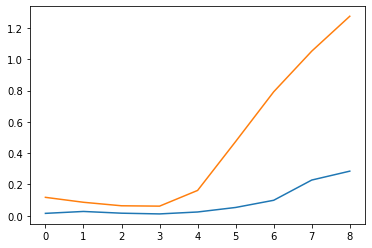

In [37]:
plt.plot(rmse_prms_batch.mean(axis=1))
plt.plot(rmse_fit_batch.mean(axis=1))

In [40]:
np.save('results/sbi_batch_rmse_noise_100k.npy', rmse_prms_batch.T)
np.save('results/sbi_batch_cost_noise_100k.npy', rmse_fit_batch.T)